# Some insights about Airbnb apartments in Seville, Spain
The purpose of this notebook is to analyse airbnb data of the city of Seville, Spain.
Throughout the notebook I'm going to answer three questions:
1. What are the neighbourhoods with more Airbnb apartments?
2. Which are the neighbourhoods with the mean apartment price more expensive?
3. How many Airbnb apartments are there inside the area (1000m) around principal monuments? 


As usual we start importing modules

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import Point
from shapely.geometry import Polygon
import pyproj

In [2]:
# Loading data
# Data source: http://insideairbnb.com/get-the-data.html

df = pd.read_csv('listings_summary.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,32347,Explore Cultural Sights from a Family-Friendly...,139939,Alejandro,Casco Antiguo,San Vicente,37.39468,-6.00183,Entire home/apt,99,2,153,2019-09-26,1.44,1,242
1,49287,BEAUTIFUL APARTMENT IN SEVILLE,224697,Walter,Casco Antiguo,Feria,37.39855,-5.99365,Entire home/apt,49,3,38,2019-08-18,0.36,1,236
2,94187,(2) ROOM + PRIVATE BATHROOM. CASA DEL BUEN VIAJE,503692,Margot,Casco Antiguo,San Bartolomé,37.39012,-5.98676,Private room,55,2,75,2019-06-05,0.77,5,354
3,108236,Sunny apt in heart of seville!!,560040,Pepe,Casco Antiguo,San Vicente,37.39645,-5.99887,Entire home/apt,58,2,141,2019-09-27,1.38,2,97
4,108568,TERRACE ALAME WIFI PARKING DOWNTOWN,589600,Miguel,Casco Antiguo,Feria,37.39939,-5.99237,Entire home/apt,65,3,80,2019-09-15,0.82,11,152


In [4]:
# Checking nulls
df.isnull().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood_group                 0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                       674
reviews_per_month                 674
calculated_host_listings_count      0
availability_365                    0
dtype: int64

There are only 2 columns with nulls: last_review and reviews_per_month. We can drop this columns because they don't have important information for the questions we want to answer 

In [5]:
df.drop(labels=['last_review','reviews_per_month'], axis=1, inplace=True)

We check again nulls to ensure all is ok

In [6]:
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Let's answer the first question:
#### 1. What are the neighbourhoods with more Airbnb apartments?

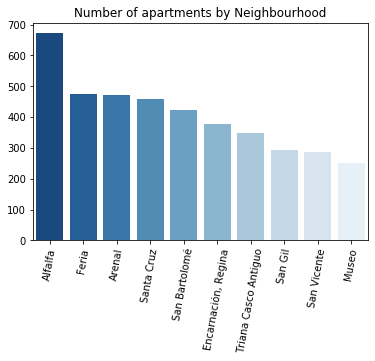

In [10]:

x1=df['neighbourhood'].value_counts()[:10].index
y1=df['neighbourhood'].value_counts()[:10].values
plt.title('Number of apartments by Neighbourhood')

ax1 = sns.barplot(x1, y1, palette='Blues_r')

ax1.set_xticklabels(labels=x1,rotation=80);

Let's explore the data to answer the second question:
#### 2. Which are the neighbourhoods with the mean apartment price more expensive?

In [11]:
# Creating a new dataframe only with the columns 'neighbourhood' and 'price'
price_df = df[['neighbourhood','price']]

In [12]:
# mean price by neighbourhood
price_by_nei = price_df.groupby('neighbourhood').mean().sort_values('price', ascending=False)[:10]
price_by_nei

,price
neighbourhood,
"Prado, Parque María Luisa",202.400000
Arenal,186.486200
no asignado,167.625000
Parque Alcosa,163.333333
Santa Cruz,160.206522
Museo,151.202381
El Porvenir,141.947368
Alfalfa,134.263393
"Encarnación, Regina",122.750663


We see this operation returns two unexpected neighbourhood categories: 'no asignado' and 'Parque Alcosa'. The first one seems dirty data and the second one is a neighbourhood far from the center or any monument and seems that don't have sense to be in that position. Let's analyse.

In [17]:
# Analysis 'no asignado'
price_df[price_df['neighbourhood']=='no asignado']

,neighbourhood,price
1801,no asignado,43
2195,no asignado,84
2319,no asignado,62
2348,no asignado,486
3583,no asignado,70
3799,no asignado,43
4132,no asignado,42
4550,no asignado,100
4618,no asignado,70
5160,no asignado,487


Clearly is dirty data so I'm going to drop them

In [14]:
price_df.drop(price_df[price_df['neighbourhood']=='no asignado'].index, inplace=True)

Let's analyse 'Parque Alcosa'

In [20]:
price_by_nei = price_df.groupby('neighbourhood').mean().sort_values('price', ascending=False)[:10]
price_by_nei

,price
neighbourhood,
"Prado, Parque María Luisa",202.400000
Arenal,186.486200
Parque Alcosa,163.333333
Santa Cruz,160.206522
Museo,151.202381
El Porvenir,141.947368
Alfalfa,134.263393
"Encarnación, Regina",122.750663
San Bartolomé,109.274232


In [21]:
# Analysis 'Parque Alcosa'
price_df[price_df['neighbourhood']=='Parque Alcosa']

,neighbourhood,price
752,Parque Alcosa,120
3531,Parque Alcosa,70
5552,Parque Alcosa,300


There are only three apartments in Parque Alcosa and one of them have a very high price that do the mean price very high. We can manage Parque Alcosa as an outlier so I'm going to drop it

In [17]:
price_df.drop(price_df[price_df['neighbourhood']=='Parque Alcosa'].index, inplace=True)

Finally we have the cleaned table and its corresponding plot

In [18]:
price_by_nei = price_df.groupby('neighbourhood').mean().sort_values('price', ascending=False)[:10]
price_by_nei

,price
neighbourhood,
"Prado, Parque María Luisa",202.400000
Arenal,186.486200
Santa Cruz,160.206522
Museo,151.202381
El Porvenir,141.947368
Alfalfa,134.263393
"Encarnación, Regina",122.750663
San Bartolomé,109.274232
Heliópolis,107.400000


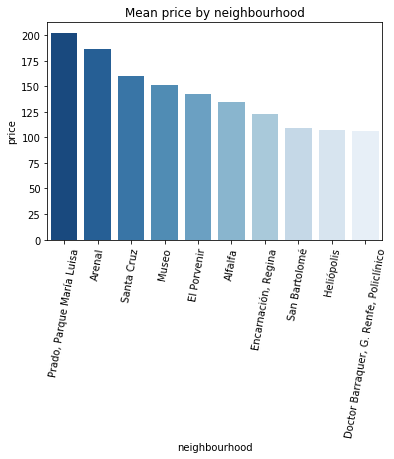

In [21]:
# Barplot: mean price by neighbourhood
x2=price_by_nei.index
y2=price_by_nei.price
plt.title('Mean price by neighbourhood')
ax2 = sns.barplot(x2, y2, palette='Blues_r')
ax2.set_xticklabels(labels=x2, rotation=80);

Let' explore the data to answer the third question:
####  3. How many Airbnb apartments are there inside the area (1000m) around principal monuments?
This is a more tricky question to analyse because we have to set the monument latitude and longitude and do a projection of the circular area around with a geo analysis approach with the 'pyproj' module and with the classes 'Point' and 'Polygon' from 'shapely' module

Firstly I have created a function to manage all this geo analysis transformations and I count the number of apartments inside the monument areas

In [23]:
def monument_area(coordinates_monument):
    # load data
    df = pd.read_csv('listings_summary.csv')
    # circular area of 1000m around Monument
    # Thanks to: https://gis.stackexchange.com/questions/252299/buffer-does-not-intersect-or-contain-the-point-used-for-the-center-of-the-buffer
    
    # Setting projection parameters
    srcProj = pyproj.Proj(init='EPSG:4326')
    dstProj = pyproj.Proj(init='EPSG:5070')
    # Coordinates of monument
    pt1 = coordinates_monument
    # Doing the projections
    x, y = pyproj.transform(srcProj, dstProj, pt1[0], pt1[1])

    pt = Point(x,y)
    # setting the distance to 1000m
    buffer = pt.buffer(1000)

    buffer_points =  zip(buffer.exterior.coords.xy[0], buffer.exterior.coords.xy[1])

    proj_buffer_points = []

    for point in buffer_points:
        x = point[0]
        y = point[1]
        x, y = pyproj.transform(dstProj, srcProj, x, y)
        proj_buffer_points.append((x,y))
                               
    Polygon(proj_buffer_points)

    # grouping latitude and longitude
    coordinates = zip(df['latitude'][:], df['longitude'][:])
    list_coord = list(coordinates)
    # Apartment counter
    count_apartment = 0 
    for i in list_coord:
        if Polygon(proj_buffer_points).contains(Point(i)):
            count_apartment += 1 
        
    return count_apartment

Now I'm going to set the coordinates of the monuments

In [24]:
# Coordinates of 'Plaza de España'
# Source: Google maps
esp_coord = (37.377105, -5.986900)
# Coordinates of 'Barrio de Santa Cruz'
cruz_coord = (37.385219, -5.988439)
# Coordinates of 'Catedral'
catedral_coord = (37.385747, -5.993056)
# Coordinates of 'Alcazar'
alcazar_coord = (37.383897, -5.991585)
# Coordinates of 'Metropol parasol, Setas' 
setas_coord = (37.393296, -5.991824)

Finally I use the monument_area function to get the results

In [28]:
print('\nNumber of apartments in 1000m around Plaza de España is {}'.format(monument_area(esp_coord)))
print('\nNumber of apartments in 1000m around Barrio de Santa Cruz is {}'.format(monument_area(cruz_coord)))
print('\nNumber of apartments in 1000m around Catedral is {}'.format(monument_area(catedral_coord)))
print('\nNumber of apartments in 1000m around Alcazar is {}'.format(monument_area(alcazar_coord)))
print('\nNumber of apartments in 1000m around Setas is {}'.format(monument_area(setas_coord)))


Number of apartments in 1000m around Plaza de España is 188

Number of apartments in 1000m around Barrio de Santa Cruz is 1997

Number of apartments in 1000m around Catedral is 2539

Number of apartments in 1000m around Alcazar is 2006

Number of apartments in 1000m around Setas is 3482


In [29]:
data = {'Monument': ['Plaza de España','Santa Cruz', 'Catedral', 'Alcazar','Setas'],
        'Number of apartments': [188, 1997, 2539, 2006, 3482]
       }
       
monument_area_df = pd.DataFrame(data=data)
monument_area_df

,Monument,Number of apartments
0,Plaza de España,188
1,Santa Cruz,1997
2,Catedral,2539
3,Alcazar,2006
4,Setas,3482


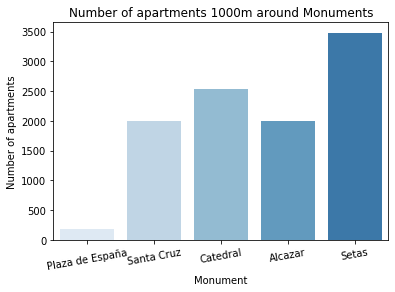

In [30]:
x5 = monument_area_df['Monument']
y5 = monument_area_df['Number of apartments']
plt.title('Number of apartments 1000m around Monuments')
ax5 = sns.barplot(x=x5, y=y5)
ax5.set_xticklabels(labels=x5,rotation=10);